In [1]:
import pandas as pd
pd.options.display.max_colwidth = 5000
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


# Text length

In [4]:
# character length of text snippet
train['text_length'] = train['text'].apply(len)

In [5]:
def split_text(x):
    return x.split()

In [6]:
# word count length of text snipped
train['word_count'] = train['text'].apply(split_text).apply(len)

In [7]:
train.describe()

,text_length,word_count
count,19579.000000,19579.000000
mean,149.057408,26.730477
std,106.800189,19.048353
min,21.000000,2.000000
25%,81.000000,15.000000
50%,128.000000,23.000000
75%,191.000000,34.000000
max,4663.000000,861.000000


## Training set

- MWS has unusually long text snippets compared to EAP and HPL

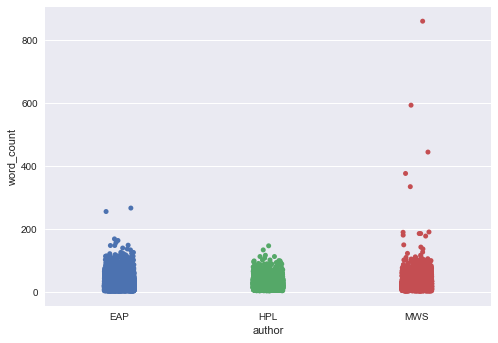

In [8]:
ax = sns.stripplot(x="author", y="word_count", data=train, jitter=True)

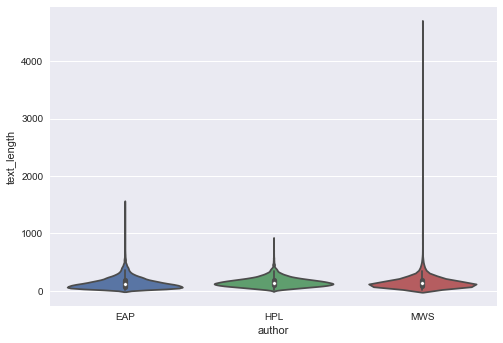

In [9]:
ax = sns.violinplot(x='author', y='text_length', data=train)

In [10]:
test['text_length'] = test['text'].apply(len)

## Test set

- We don't know the author
- There are not as many unusually long text snippets in the training set

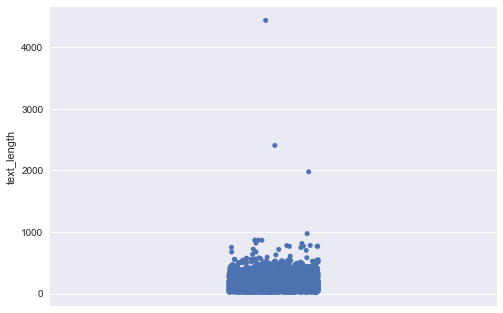

In [11]:
ax = sns.stripplot(y='text_length', data=test, jitter=True)

# Named Entity Recognition

- explore Persons and Places mentioned in the text snippets
- check if there is an overlap, otherwise these could be highly informative features

In [12]:
import spacy

In [13]:
nlp = spacy.load("en_core_web_md")

In [14]:
ner = {}

In [15]:
# loop over text and associated authors
for text, author in zip(train.text, train.author):
    doc = nlp(text) # spacy pipeline
    if doc.ents:    # check for entities
        # print(author)
        for ent in doc.ents: # for each entity
            if ent.label_ in ["PERSON", "GPE", "LOC"]: # focus persons, places
                # print(ent.label_, ent.text)
                
                # populate author dictionary
                if author in ner.keys():
                    if ent.text not in ner[author]:
                        ner[author].append(ent.text)
                else:
                    ner[author] = [ent.text]

In [16]:
for key, val in ner.items():
    print(key, val)
    print("")

EAP ['Epicurus', 'California', "Von Kempelen's", 'Underduk', 'Ellison', 'Mein Gott', 'Latin', 'Theodore Sinivate', 'Kidd', 'Lofoden', 'Moskoe', 'Pierre Moreau', "Madame L'Espanaye", 'Hebrews', 'Athens', 'Epimenides', 'Laertius', 'Alexander', 'John Smith', 'Gazette', 'Thomas Hawk', 'Jupiter', 'Jxhn', 'Perdidit', 'Ferdinand Fitz Fossillus Feltspar', 'Launcelot', 'Cotopaxi', 'Flimen', 'Dupin', 'I. "Nose and', 'Mark Antony', 'Von Kempelen', 'Valence', 'Marie', 'P.', 'Baron', 'Windenough', 'Paris', 'William Wilson', 'Oxford', 'Keats', 'Oppodeldoc', 'Luchesi', 'Amontillado', 'Sherry', 'Everard Bringhurst', 'Osborne', 'Mason', 'Holland', 'Rotterdam', "D'Avisson Davidson", 'Mademoiselle', 'Marston', 'Geneva', 'Eleonora', 'Pompey', 'B.', 'M. St. Eustache', 'M. Beauvais', 'Greece', 'M. Maillardet', 'Rome', 'Eugenie', 'Vell', 'Bobby', 'Edward Stapleton', 'Frederick', 'Helseggen', 'Suky Snobbs', 'Thingum', 'Crab', 'Fortunato', 'Diana', "Mademoiselle L'Espanaye", 'Dumas', 'Etienne', 'Gad Fly" it', 

In [17]:
# only keep unique persons, locations for each Author

In [18]:
ner_EAP = []
for item in ner['EAP']:
    if item not in ner['MWS']+ner['HPL']:
        ner_EAP.append(item)

In [19]:
ner_MWS = []
for item in ner['MWS']:
    if item not in ner['EAP']+ner['HPL']:
        ner_MWS.append(item)

In [20]:
ner_HPL = []
for item in ner['HPL']:
    if item not in ner['EAP']+ner['MWS']:
        ner_HPL.append(item)

In [21]:
print(len(ner['EAP']), len(ner_EAP))

897 796


In [22]:
print(len(ner['MWS']), len(ner_MWS))

402 305


In [23]:
print(len(ner['HPL']), len(ner_HPL))

982 898


In [24]:
test_list = ['Epicurus', 'Underduk', 'This string is not in list']

In [25]:
list(set(test_list).intersection(ner_EAP))

['Epicurus', 'Underduk']

In [26]:
if any(item in test for item in ner_EAP):
    print(test)

# Testing for author-specific Named Entities in the Test data

In [27]:
EAP = []
HPL = []
MWS = []

In [28]:
# loop over text and associated authors
for text in test.text:
    
    EAP_ner_counter = 0
    HPL_ner_counter = 0
    MWS_ner_counter = 0
    
    doc = nlp(text) # spacy pipeline
    if doc.ents:    # check for entities
        # print(doc.ents)
        for ent in doc.ents:
            if ent.text in ner_EAP:
                # print("EAP")
                # print(ent.text)
                # print(text)
                EAP_ner_counter += 1
            elif ent.text in ner_HPL:
                # print("HPL")
                # print(ent.text)
                # print(text)
                HPL_ner_counter += 1
            elif ent.text in ner_MWS:
                # print("MWS")
                # print(ent.text)
                # print(text)
                MWS_ner_counter += 1
            else:
                # Text contains unknown entities
                continue
    # print("EAP", EAP_ner_counter)
    # print("HPL", HPL_ner_counter)
    # print("MWS", MWS_ner_counter)
    EAP.append(EAP_ner_counter)
    HPL.append(HPL_ner_counter)
    MWS.append(MWS_ner_counter)

In [29]:
ner_columns = [EAP, HPL, MWS]

In [30]:
ner_df = pd.DataFrame({"EAP": EAP, "HPL": HPL, "MWS": MWS})

In [31]:
pd.concat([test, ner_df], axis=1)

,id,text,text_length,EAP,HPL,MWS
0,id02310,"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield.",110,0,0,0
1,id24541,"If a fire wanted fanning, it could readily be fanned with a newspaper, and as the government grew weaker, I have no doubt that leather and iron acquired durability in proportion, for, in a very short time, there was not a pair of bellows in all Rotterdam that ever stood in need of a stitch or required the assistance of a hammer.",330,0,0,0
2,id00134,"And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen floor, and a number of singular beetles crawling in the shadowy corners.",189,0,0,0
3,id27757,"While I was thinking how I should possibly manage without them, one actually tumbled out of my head, and, rolling down the steep side of the steeple, lodged in the rain gutter which ran along the eaves of the main building.",223,0,0,0
4,id04081,I am not sure to what limit his knowledge may extend.,53,0,0,0
5,id27337,"""The thick and peculiar mist, or smoke, which distinguishes the Indian Summer, and which now hung heavily over all objects, served, no doubt, to deepen the vague impressions which these objects created.",202,0,0,0
6,id24265,"That which is not matter, is not at all unless qualities are things.",68,0,0,0
7,id25917,"I sought for repose although I did not hope for forgetfulness; I knew I should be pursued by dreams, but did not dread the frightful one that I really had.",155,0,0,0
8,id04951,"Upon the fourth day of the assassination, a party of the police came, very unexpectedly, into the house, and proceeded again to make rigorous investigation of the premises.",172,0,0,0
9,id14549,"""The tone metaphysical is also a good one.",42,0,0,0


## Number of author-specific entity mentions in test phrases 

In [32]:
sum(EAP)

505

In [33]:
sum(HPL)

797

In [34]:
sum(MWS)

467

In [39]:
pd.Series(ner_EAP).to_csv('data/ner_EAP.csv', index=False)
pd.Series(ner_HPL).to_csv('data/ner_HPL.csv', index=False)
pd.Series(ner_MWS).to_csv('data/ner_MWS.csv', index=False)